## *Imports*

In [1]:
import sys # system functions (ie. exiting the program)
import os # operating system functions (ie. path building on Windows vs. MacOs)
import time # for time operations
import uuid # for generating unique file names
import math # math functions

from IPython.display import display as ipydisplay, Image, clear_output, HTML # for interacting with the notebook better

import numpy as np # matrix operations (ie. difference between two matricies)
import cv2 # (OpenCV) computer vision functions (ie. tracking)
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
print('OpenCV Version: {}.{}.{}'.format(major_ver, minor_ver, subminor_ver))

import matplotlib.pyplot as plt # (optional) for plotting and showing images inline
%matplotlib inline

from keras import backend as K
print('Keras image data format: {}'.format(K.image_data_format()))

OpenCV Version: 4.2.0


Bad value in file '/Users/arynas/.matplotlib/matplotlibrc', line 1 ('backend: TkAggy'): Key backend: 'tkaggy' is not a valid value for backend; supported values are ['GTK3Agg', 'GTK3Cairo', 'GTK4Agg', 'GTK4Cairo', 'MacOSX', 'nbAgg', 'QtAgg', 'QtCairo', 'Qt5Agg', 'Qt5Cairo', 'TkAgg', 'TkCairo', 'WebAgg', 'WX', 'WXAgg', 'WXCairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template']


Keras image data format: channels_last


## *Constants*

In [2]:
IMAGES_FOLDER = os.path.join('images') # images for visuals

MODEL_PATH = os.path.join('model')
MODEL_FILE = os.path.join(MODEL_PATH, 'hand_model_gray.hdf5') # path to model weights and architechture file
MODEL_HISTORY = os.path.join(MODEL_PATH, 'model_history.txt') # path to model training history

## *Tools*

### Displaying images

#### Fix colour channel ordering for plotting

Matplotlib and OpenCV order colour channels in image matricies slightly differently, RGB and BGR respectively. We need to reorder the colour channels if we want to plot OpenCV images with Matplotlib.

In [3]:
def bgrtorgb(image):
    return cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)

#### Jupyter Notebook image display

In [4]:
def show_image(name):
    """
    Showing image files.
    """
    fname = os.path.join(IMAGES_FOLDER, name)
    ipydisplay(Image(fname))

In [5]:
def plot_image(image, figsize=(8,8), recolour=False):
    """
    Plotting image matricies.
    """
    if recolour: image = bgrtorgb(image)
    plt.figure(figsize=figsize)
    if image.shape[-1] == 3:
        plt.imshow(image)
    elif image.shape[-1] == 1 or len(image.shape) == 2:
        plt.imshow(image, cmap='gray')
    else:
        raise Exception("Image has invalid shape.")

## *Computer Vision Concepts*

### What computers see

Computers 'look' at images as multidimensional arrays or matricies but they can also be treated like functions (ex. taking the derivative over an image's x-axis).

Below an image is loaded from the file system and loaded into memory. This matrix is 387 x 600 x 3 which represents the number of rows x number of columns x number of colour channels (RGB/BGR).

We can then plot that data to view the image.

Note: When images are loaded in OpenCV, they return BGR (blue, green, red) channels, where as matplotlib expects RGB (red, green, blue). Therefore, we need  to convert the loaded image matrix from BGR to RGB.

Image Shape:  (480, 852, 3) 


Image Matrix: 
 [[[26 33 51]
  [26 33 51]
  [26 33 51]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[26 33 51]
  [26 33 51]
  [27 34 52]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[26 33 51]
  [27 34 52]
  [27 34 52]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 ...

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 3  3  5]
  [ 3  3  5]
  [ 3  3  5]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 3  3  5]
  [ 3  3  5]
  [ 3  3  5]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 3  3  5]
  [ 3  3  5]
  [ 3  3  5]]] 


Image Plotted:


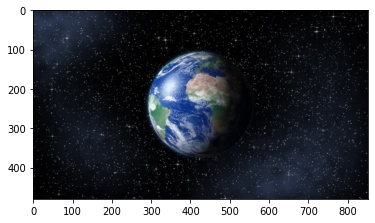

In [6]:
earth_fname = os.path.join(IMAGES_FOLDER, 'earth.jpg')
earth_img = cv2.imread(earth_fname)
# comment out the line below to see the colour difference
earth_img = cv2.cvtColor(earth_img, cv2.COLOR_BGR2RGB)
plt.imshow(earth_img)

print('Image Shape: ', earth_img.shape, '\n\n')
print('Image Matrix: \n', earth_img, '\n\n')
print('Image Plotted:')

### Image Filters and Functions

Many times, images contain complex information that isn't need for a computation or reduces the speed of computation without much value added.

#### Blurring


Blurring is useful when there is noise in an image you want to remove.

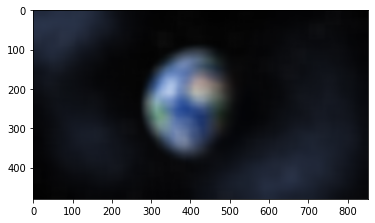

In [7]:
box_blur_img = earth_img.copy()
box_blur_img = cv2.blur(box_blur_img, (41, 41))
plt.imshow(box_blur_img)

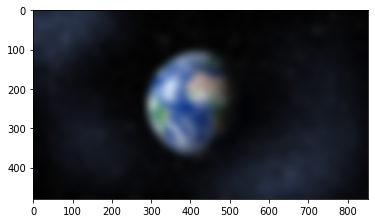

In [8]:
blur_img = earth_img.copy()
blur_img = cv2.GaussianBlur(blur_img, (41, 41), 10)
plt.imshow(blur_img)

#### Dilating

Dilation, as it sounds, dilates pixel neighbourhoods by finding maximums over the image by the kernel size given. This is useful for expanding selections (we'll look at this later).

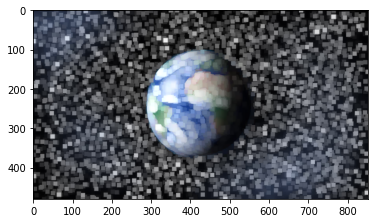

In [9]:
dilate_img = earth_img.copy()
dilate_img = cv2.dilate(dilate_img, np.ones((10,10), dtype=np.uint8), iterations=1)
plt.imshow(dilate_img)

#### Erosion

Erosion is the opposite of dilation, useful for remove noise.

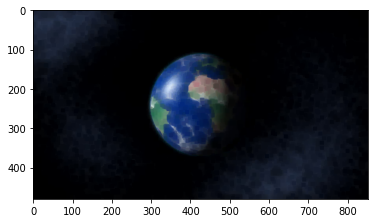

In [10]:
erosion_img = earth_img.copy()
erosion_img = cv2.erode(erosion_img, np.ones((10,10), dtype=np.uint8), iterations=1)
plt.imshow(erosion_img)

#### Canny edge detector

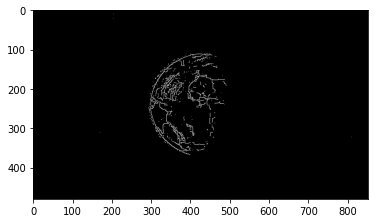

In [11]:
canny_img = earth_img.copy()
canny_img = cv2.erode(canny_img, np.ones((12,12), dtype=np.uint8), iterations=1)
thresh = 75
edges = cv2.Canny(canny_img,thresh,thresh)
plt.imshow(edges.astype(np.uint8), cmap='gray')

#### Thresholding

Thresholding can be thought of as a function applied to each pixel of an image. This function takes a min and max thresholding values and if the pixel value falls in this range, it will 'return' the pixel, if not it will 'return' a black pixel.

Generally, thresholding is applied to a greyscale image, but may also be applied to colour images, following a similair principle.

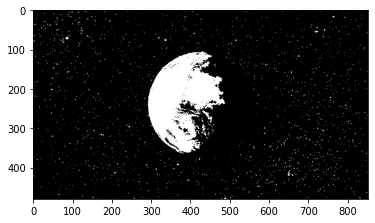

In [12]:
thresh_img = earth_img.copy()
thresh_img = cv2.cvtColor(thresh_img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(thresh_img, 80, 255, cv2.THRESH_BINARY)
plt.imshow(thresh, cmap='gray')

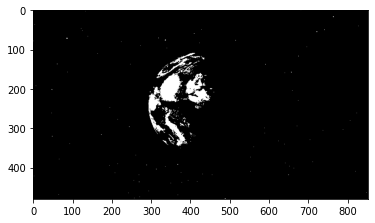

In [13]:
thresh_img = earth_img.copy()
thresh_img = cv2.cvtColor(thresh_img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(thresh_img, 155, 255, cv2.THRESH_BINARY)
plt.imshow(thresh, cmap='gray')

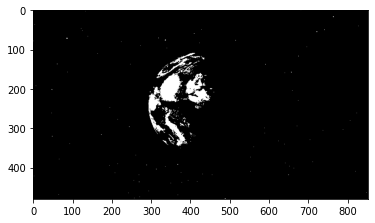

In [14]:
thresh_img = earth_img.copy()
thresh_img = cv2.cvtColor(thresh_img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(thresh_img, 155, 170, cv2.THRESH_BINARY)
plt.imshow(thresh, cmap='gray')

### Background Subtraction Techniques

#### Using a background image to find differences (can be used for images and video)

This technique requires a background image to find the difference between the background and the current frame to find what as changed. This difference creates a 'mask' that represents where in the image the foreground is. A draw back of this algorithm is that any movement of the camera, change of lighting, change in focus, etc. will make the current frame totally different from the background image.

The algorithm:
* load in the background image and the current frame
* find the absolute difference between the images
* create a mask that contains a 'map' of pixels that should be 'on or off'
* apply the mask to the current frame to extract the foreground by iterating over each pixel and copying all pixels from the current frame that should be part of the foreground

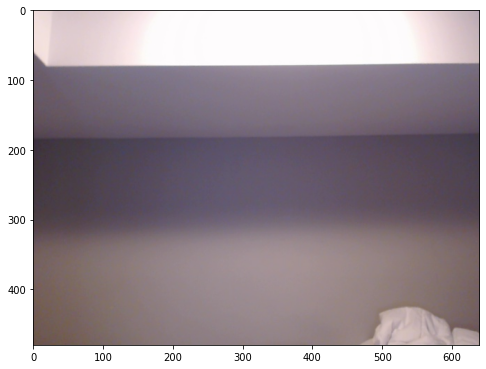

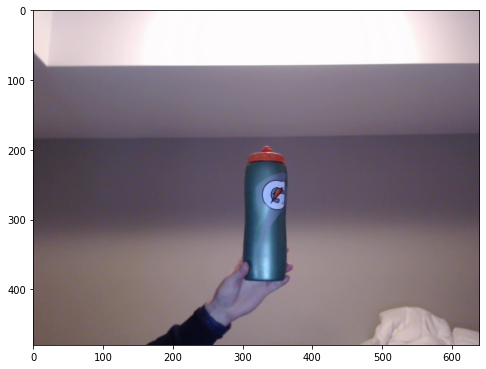

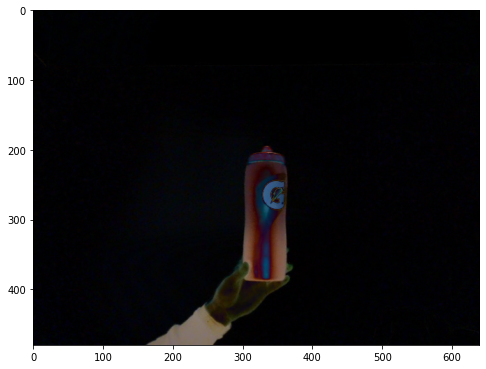

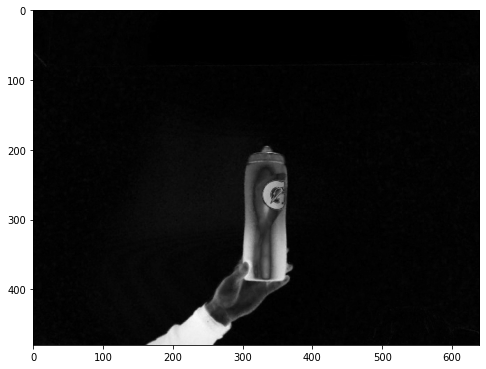

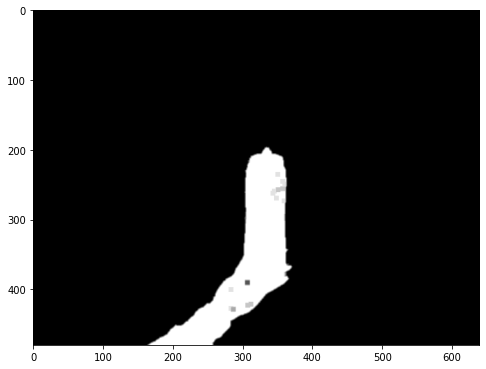

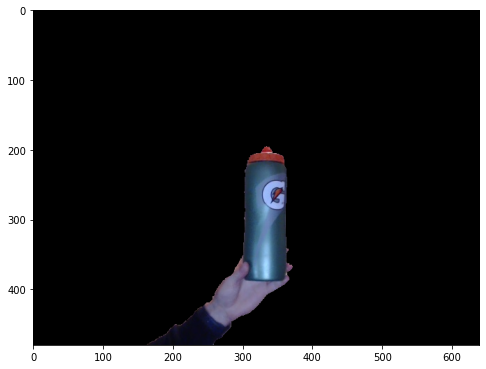

In [15]:
bg_img = cv2.imread(os.path.join(IMAGES_FOLDER, 'bg.jpg'))
current_frame_img = cv2.imread(os.path.join(IMAGES_FOLDER, 'current_frame.jpg'))

diff = cv2.absdiff(bg_img, current_frame_img)
mask = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
th, mask_thresh = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)
mask_blur = cv2.GaussianBlur(mask_thresh, (3, 3), 10)
mask_erosion = cv2.erode(mask_blur, np.ones((5,5), dtype=np.uint8), iterations=1)

mask_indexes = mask_erosion > 0

foreground = np.zeros_like(current_frame_img, dtype=np.uint8)
for i, row in enumerate(mask_indexes):
    foreground[i, row] = current_frame_img[i, row]

plot_image(bg_img, recolour=True)
plot_image(current_frame_img, recolour=True)
plot_image(diff, recolour=True)
plot_image(mask)
plot_image(mask_erosion)
plot_image(foreground, recolour=True)

#### Using motion based background subtraction algorithms (mainly video)

These algorithms are most used for video. The algorithm looks at a series of frames and computes which pixels are most static and identifies the foreground by the pixels that are moving. The MOG2 and KNN background subtractors are two different algorithms.

In [16]:
ERODE = True

fgbg = cv2.createBackgroundSubtractorMOG2()
# fgbg = cv2.createBackgroundSubtractorKNN()

video = cv2.VideoCapture(os.path.join(IMAGES_FOLDER, 'bg_subtract_movement.mp4'))

while True:
    time.sleep(0.025)
    
    timer = cv2.getTickCount()
    
    # Read a new frame
    success, frame = video.read()
    if not success:
        # Frame not successfully read from video capture
        break
        
    fgmask = fgbg.apply(frame)
    
    # Apply erosion to clean up noise
    if ERODE:
        fgmask = cv2.erode(fgmask, np.ones((3,3), dtype=np.uint8), iterations=1)
    
    # Calculate Frames per second (FPS)
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)
    # Display FPS on frame
    cv2.putText(fgmask, "FPS : " + str(int(fps)), (100, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255, 255, 255), 2)
 
    # Display result
    cv2.imshow("fgmask", fgmask)
    
    k = cv2.waitKey(1) & 0xff
    if k == 27: break # ESC pressed
        
cv2.destroyAllWindows()
video.release()

### Contours

Finding contours is done by finding points or corners in an image and connecting those that have the same color or intensity.

#### Finding contours and sorting contours

Here we sort the contours by area and get the 4 largest contours, but we can also find all contours that are greater than a certain size. We can also fill contours by passing -1 to the last parameter of cv2.drawContours().

You can also use contours for masking similair to how it was done above for background subtraction.

In [ ]:
OUTLINE = True
LRG_ONLY = True

# window to hold the trackbar
img = np.zeros((300,512,3), np.uint8)
cv2.namedWindow('image')

# create trackbar
cv2.createTrackbar('Thresh', 'image', 0, 255, lambda x: None)

earth_fname = os.path.join(IMAGES_FOLDER, 'earth.jpg')
earth_img = cv2.imread(earth_fname)

while True:
    thresh_min = cv2.getTrackbarPos('Thresh','image')
    
    contour_img = earth_img.copy()
    contour_img = cv2.cvtColor(contour_img, cv2.COLOR_BGR2GRAY)
    ret, contour_img_thresh = cv2.threshold(contour_img, thresh_min, 255, 0)
    contours, hierarchy = cv2.findContours(contour_img_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    if LRG_ONLY:
        cnts = [x for x in contours if cv2.contourArea(x) > 20000]
    else:
        cnts = sorted(contours, key = cv2.contourArea, reverse = True)[:3]

    if OUTLINE:
        # Draw only outlines
        contour_img_display = cv2.drawContours(earth_img.copy(), cnts, -1, (238, 255, 0), 2)
    else:
        # Draw filled contours
        contour_img_display = cv2.drawContours(earth_img.copy(), cnts, -1, (238, 255, 0), -1)

    contour_img_display = cv2.cvtColor(contour_img_display, cv2.COLOR_BGR2RGB)
    
    cv2.imshow('image', contour_img_display)
    cv2.imshow('thresh', contour_img_thresh)
    
    k = cv2.waitKey(1) & 0xff
    if k == 27: break # ESC pressed
        

cv2.destroyAllWindows()    
# plot_image(contour_img_thresh)
# plot_image(contour_img_display, recolour=True) 

### Tracking

Tracking is a very complex topic and we will simply use OpenCV's tracking algorithms to track objects. For this tutorial, we will use the Kernelized Correlation Filters (KCF) tracking as it performs well and provides built in tracking error detection.

Available tracking algorithms:
* MIL
* BOOSTING
* MEDIANFLOW
* TLD
* KCF

In [ ]:
# Set up tracker.
def setup_tracker(ttype):
    tracker_types = ['BOOSTING', 'MIL', 'KCF', 'TLD', 'MEDIANFLOW', 'GOTURN']
    tracker_type = tracker_types[ttype]

    if tracker_type == 'BOOSTING':
        tracker = cv2.TrackerBoosting_create()
    if tracker_type == 'MIL':
        tracker = cv2.TrackerMIL_create()
    if tracker_type == 'KCF':
        tracker = cv2.TrackerKCF_create()
    if tracker_type == 'TLD':
        tracker = cv2.TrackerTLD_create()
    if tracker_type == 'MEDIANFLOW':
        tracker = cv2.TrackerMedianFlow_create()
    if tracker_type == 'GOTURN':
        tracker = cv2.TrackerGOTURN_create()
    
    return tracker

In [ ]:
video = cv2.VideoCapture("demos/images/moving_subject_scale.mp4")
# video = cv2.VideoCapture(0)

# Read first frame
success, frame = video.read()
if not success:
    print("first frame not read")
    sys.exit()

tracker = setup_tracker(4)

# Select roi for bbox
bbox = cv2.selectROI(frame, False)
cv2.destroyAllWindows()

# Initialize tracker with first frame and bounding box
tracking_success = tracker.init(frame, bbox)

while True:
    time.sleep(0.02)
    
    timer = cv2.getTickCount()
    
    # Read a new frame
    success, frame = video.read()
    if not success:
        # Frame not successfully read from video capture
        break
        
    # Update tracker
    tracking_success, bbox = tracker.update(frame)
    
    # Draw bounding box
    if tracking_success:
        # Tracking success
        p1 = (int(bbox[0]), int(bbox[1]))
        p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
        cv2.rectangle(frame, p1, p2, (255, 0, 0), 2, 1)        
    else:
        # Tracking failure
        cv2.putText(frame, "Tracking failure detected", (100, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)
        
    # Calculate Frames per second (FPS)
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)
    # Display FPS on frame
    cv2.putText(frame, "FPS : " + str(int(fps)), (100, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255, 0, 0), 2)
    
    # Display result
    cv2.imshow("frame", frame)
    
    k = cv2.waitKey(1) & 0xff
    if k == 27: break # ESC pressed
        
cv2.destroyAllWindows()
video.release()

### Collecting data

The next objective is to recognize which gesture a hand is posed in. We will train our neural network on 4 gestures: fist, five, point and swing. For this network we will train the network on the mask to reduce dimensionality. Doing this makes it a more simple problem for the network to model, while sacrificing information stored in the colours of an image.

Here, we track our hand with the background subtracted and thresholded. Everytime you hit 's' a screen capture of your cropped hand is saved.

In [ ]:
classes = {
    0: 'fist',
    1: 'five',
    2: 'point',
    3: 'swing'
}

CURR_POSE = 'five'
DATA = 'training_data'

# Helper function for applying a mask to an array
def mask_array(array, imask):
    if array.shape[:2] != imask.shape:
        raise Exception("Shapes of input and imask are incompatible")
    output = np.zeros_like(array, dtype=np.uint8)
    for i, row in enumerate(imask):
        output[i, row] = array[i, row]
    return output


# Begin capturing video
video = cv2.VideoCapture(1)
if not video.isOpened():
    print("Could not open video")
    sys.exit()


# Read first frame
ok, frame = video.read()
if not ok:
    print("Cannot read video")
    sys.exit()
# Use the first frame as an initial background frame
bg = frame.copy()


# Kernel for erosion and dilation of masks
kernel = np.ones((3,3),np.uint8)


# Tracking
# Bounding box -> (TopRightX, TopRightY, Width, Height)
bbox_initial = (60, 60, 170, 170)
bbox = bbox_initial
# Tracking status, -1 for not tracking, 0 for unsuccessful tracking, 1 for successful tracking
tracking = -1


# Text display positions
positions = {
    'hand_pose': (15, 40),
    'fps': (15, 20)
}


# Image count for file name
img_count = 0

# Capture, process, display loop    
while True:
    # Read a new frame
    ok, frame = video.read()
    display = frame.copy()
    if not ok:
        break
        
        
    # Start timer
    timer = cv2.getTickCount()

    
    # Processing
    # First find the absolute difference between the two images
    diff = cv2.absdiff(bg, frame)
    mask = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    # Threshold the mask
    th, thresh = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)
    # Opening, closing and dilation
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    img_dilation = cv2.dilate(closing, kernel, iterations=2)
    # Get mask indexes
    imask = img_dilation > 0
    # Get foreground from mask
    foreground = mask_array(frame, imask)
    foreground_display = foreground.copy()
    
    
    # If tracking is active, update the tracker
    if tracking != -1:
        tracking, bbox = tracker.update(foreground)
        tracking = int(tracking)
        
        
    # Use numpy array indexing to crop the foreground frame
    hand_crop = img_dilation[int(bbox[1]):int(bbox[1]+bbox[3]), int(bbox[0]):int(bbox[0]+bbox[2])]
    
        
    # Draw bounding box
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(foreground_display, p1, p2, (255, 0, 0), 2, 1)
    cv2.rectangle(display, p1, p2, (255, 0, 0), 2, 1)
    
        
    # Calculate Frames per second (FPS)
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)
    # Display FPS on frame
    cv2.putText(foreground_display, "FPS : " + str(int(fps)), positions['fps'], cv2.FONT_HERSHEY_SIMPLEX, 0.65, (50, 170, 50), 2)
    cv2.putText(display, "FPS : " + str(int(fps)), positions['fps'], cv2.FONT_HERSHEY_SIMPLEX, 0.65, (50, 170, 50), 2)
    
    
    # Display result
    cv2.imshow("display", display)
    # Display diff
    cv2.imshow("diff", diff)
    # Display thresh
    cv2.imshow("thresh", thresh)
    # Display mask
    cv2.imshow("img_dilation", img_dilation)
    try:
        # Display hand_crop
        cv2.imshow("hand_crop", hand_crop)
    except:
        pass
    # Display foreground_display
    cv2.imshow("foreground_display", foreground_display)
    
    
    k = cv2.waitKey(1) & 0xff
    
    if k == 27: break # ESC pressed
    elif k == 114 or k == 112: 
        # r pressed
        bg = frame.copy()
        bbox = bbox_initial
        tracking = -1
    elif k == 116:
        # t pressed
        # Initialize tracker with first frame and bounding box
        tracker = setup_tracker(2)
        tracking = tracker.init(frame, bbox)
    elif k == 115:
        # s pressed
        img_count += 1
        fname = os.path.join(DATA, CURR_POSE, "{}_{}.jpg".format(CURR_POSE, img_count))
        print(fname, hand_crop)
        cv2.imwrite(fname, hand_crop)
        print()
    elif k != 255: print(k)
        
cv2.destroyAllWindows()
video.release()